**Sentiment Analysis Using** ***LSTM***

In [61]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import nltk
import re,string,unicodedata
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
import re
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import keras
from keras.layers import Bidirectional, LSTM
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [2]:
! pip install kaggle

In [3]:
# prompt: configer the path of kaggle.json file

!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [4]:
! kaggle datasets download -d kazanova/sentiment140

sentiment140.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
# extracting the data
from zipfile import ZipFile
dataset = '/content/sentiment140.zip'

with ZipFile(dataset,'r') as zip:
  zip.extractall()
  print ('The dataset is exracted')

The dataset is exracted


In [6]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [8]:
dataset_columns = ["Target", "ID's", "Date", "Flag", "User", "Text"]
twitter_data = pd.read_csv('/content/training.1600000.processed.noemoticon.csv', encoding = 'ISO-8859-1', names = dataset_columns)

In [9]:
twitter_data.head()

,Target,ID's,Date,Flag,User,Text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [10]:
twitter_data.isnull().sum()

Target    0
ID's      0
Date      0
Flag      0
User      0
Text      0
dtype: int64

In [11]:
# Converting Target veriable to 0 and 1
twitter_data.replace({'Target':{4:1}}, inplace=True)

In [14]:
twitter_data.tail()

,Target,ID's,Date,Flag,User,Text
1599995,1,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,1,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,1,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,1,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...
1599999,1,2193602129,Tue Jun 16 08:40:50 PDT 2009,NO_QUERY,RyanTrevMorris,happy #charitytuesday @theNSPCC @SparksCharity...


In [17]:
port_stem = PorterStemmer()

In [18]:
def stemming(content):
  stemmed_content = re.sub('[^a-zA-Z]',' ',content) # Keeps only alphabets
  stemmed_content =stemmed_content.lower() # To Lower Case
  stemmed_content =stemmed_content.split()
  stemmed_content = [port_stem.stem(word) for word in stemmed_content if not word in stopwords.words('english')] # For stopped words
  stemmed_content = ' '.join(stemmed_content)  # To join all tweets together

  return stemmed_content

In [19]:
twitter_data['stemmed_content'] = twitter_data['Text'].apply(stemming)

In [20]:
twitter_data.head()

,Target,ID's,Date,Flag,User,Text,stemmed_content
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",switchfoot http twitpic com zl awww bummer sho...
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,upset updat facebook text might cri result sch...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,kenichan dive mani time ball manag save rest g...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,whole bodi feel itchi like fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",nationwideclass behav mad see


In [22]:
twitter_data.shape

(1600000, 7)

In [23]:
# Seperating the data and label
X = twitter_data['stemmed_content'].values
Y = twitter_data['Target'].values

In [24]:
Y.shape

(1600000,)

In [25]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, random_state=16)

In [27]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(1280000,)
(1280000,)
(320000,)
(320000,)


In [29]:
tokenizer = Tokenizer()

In [63]:
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
print(word_index)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [31]:
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)


Vocabulary Size : 461344


In [32]:
# convert train dataset to sequence and pad sequences
train_sequences = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_sequences, maxlen=30)
# convert Test dataset to sequence and pad sequences
test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_sequences, maxlen=30)


In [35]:
Y_train = Y_train.reshape(-1,1)
Y_test = Y_test.reshape(-1,1)

In [36]:
print(train_padded.shape)
print(Y_train.shape)
print(test_padded.shape)
print(Y_test.shape)


(1280000, 30)
(1280000, 1)
(320000, 30)
(320000, 1)


In [38]:
train_padded[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0, 1023,    2,   77,    5,   10, 8282], dtype=int32)

In [47]:
# Model initialization with Bidirectional LSTM
model = keras.Sequential([
    keras.layers.Embedding( vocab_size, 300 , input_length=30 ,trainable=False ),
    LSTM(64),  # Using  LSTM
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy',metrics=['accuracy'])

model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 30, 300)           138403200 
                                                                 
 lstm_3 (LSTM)               (None, 64)                93440     
                                                                 
 dense_9 (Dense)             (None, 32)                2080      
                                                                 
 dense_10 (Dense)            (None, 32)                1056      
                                                                 
 dense_11 (Dense)            (None, 1)                 33        
                                                                 
Total params: 138499809 (528.33 MB)
Trainable params: 96609 (377.38 KB)
Non-trainable params: 138403200 (527.97 MB)
_________________________________________________________________


In [48]:
history = model.fit(train_padded, Y_train , batch_size=1024, epochs=10,
                    validation_data=(test_padded, Y_test))

Epoch 1/10
1250/1250 [==============================] - 554s 441ms/step - loss: 0.6458 - accuracy: 0.6292 - val_loss: 0.5673 - val_accuracy: 0.6984
Epoch 2/10
1250/1250 [==============================] - 548s 438ms/step - loss: 0.6357 - accuracy: 0.6347 - val_loss: 0.6545 - val_accuracy: 0.6230
Epoch 3/10
1250/1250 [==============================] - 541s 433ms/step - loss: 0.5910 - accuracy: 0.6807 - val_loss: 0.6342 - val_accuracy: 0.6648
Epoch 4/10
1250/1250 [==============================] - 522s 417ms/step - loss: 0.5675 - accuracy: 0.7065 - val_loss: 0.5565 - val_accuracy: 0.7214
Epoch 5/10
1250/1250 [==============================] - 541s 433ms/step - loss: 0.5533 - accuracy: 0.7115 - val_loss: 0.5529 - val_accuracy: 0.7228
Epoch 6/10
1250/1250 [==============================] - 543s 434ms/step - loss: 0.5176 - accuracy: 0.7445 - val_loss: 0.5137 - val_accuracy: 0.7518
Epoch 7/10
1250/1250 [==============================] - 546s 437ms/step - loss: 0.4960 - accuracy: 0.7579 - val_

In [57]:
prediction = model.predict(test_padded)


10000/10000 [==============================] - 177s 18ms/step


In [51]:
print(prediction.shape)

(320000, 1)


In [58]:
# Get labels based on probability 1 if p>= 0.5 else 0
pred_labels = []
for i in prediction:
    if i >= 0.5:
        pred_labels.append(1)
    else:
        pred_labels.append(0)
print("Accuracy of prediction on test set : ", accuracy_score(Y_test,pred_labels))

Accuracy of prediction on test set :  0.7580875


In [59]:
# Calculate performance metrics
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
lr_accuracy = accuracy_score(Y_test, pred_labels)
lr_confusion = confusion_matrix(Y_test, pred_labels)
lr_report = classification_report(Y_test, pred_labels)
lr_precision = precision_score(Y_test, pred_labels)
lr_recall = recall_score(Y_test, pred_labels)
lr_f1_score = f1_score(Y_test, pred_labels)
lr_roc_auc = roc_auc_score(Y_test, pred_labels)

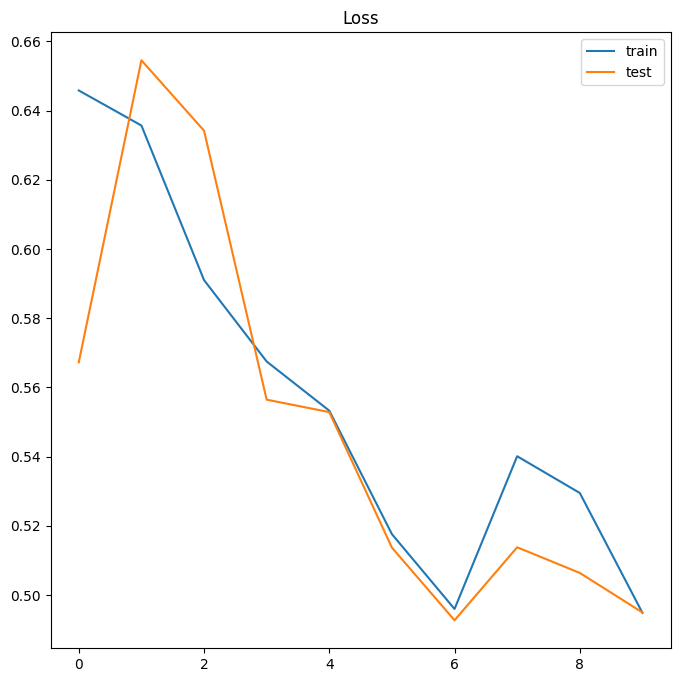

In [52]:

plt.figure(figsize=(8, 8))
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

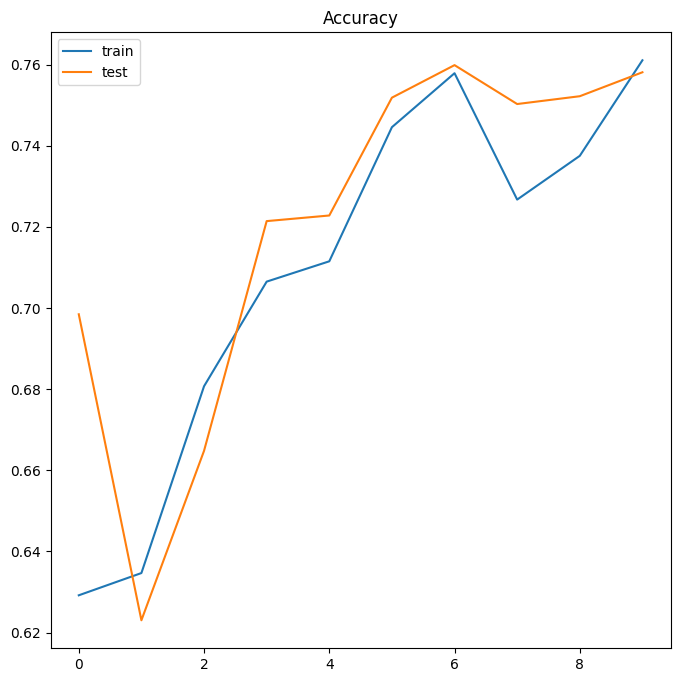

In [53]:
plt.figure(figsize=(8, 8))
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [60]:
# Print performance metrics
print("Accuracy:")
print(lr_accuracy)
print()

print("Confusion Matrix:")
print(lr_confusion)
print()

print("Classification Report:")
print(lr_report)
print()

print("Precision Score:")
print(lr_precision)
print()

print("Recall Score:")
print(lr_recall)
print()

print("F1 Score:")
print(lr_f1_score)
print()

print("Area Under the ROC Curve (AUC-ROC):")
print(lr_roc_auc)
print()

Accuracy:
0.7580875

Confusion Matrix:
[[111437  48372]
 [ 29040 131151]]

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.70      0.74    159809
           1       0.73      0.82      0.77    160191

    accuracy                           0.76    320000
   macro avg       0.76      0.76      0.76    320000
weighted avg       0.76      0.76      0.76    320000


Precision Score:
0.7305526311391856

Recall Score:
0.818716407288799

F1 Score:
0.7721259647821404

Area Under the ROC Curve (AUC-ROC):
0.7580150377401013

